In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 40000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-06-25_13-51_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [4]:
#df = df.loc['20190101':]

In [5]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [6]:
allocs

ES       0.5
NQ       0.5
total    1.0
dtype: float64

In [7]:
df.groupby('contract').realizedPNL.sum()

contract
ES    12864.4
NQ    18920.8
Name: realizedPNL, dtype: float64

In [8]:
df.realizedPNL.sum()

31785.199999999997

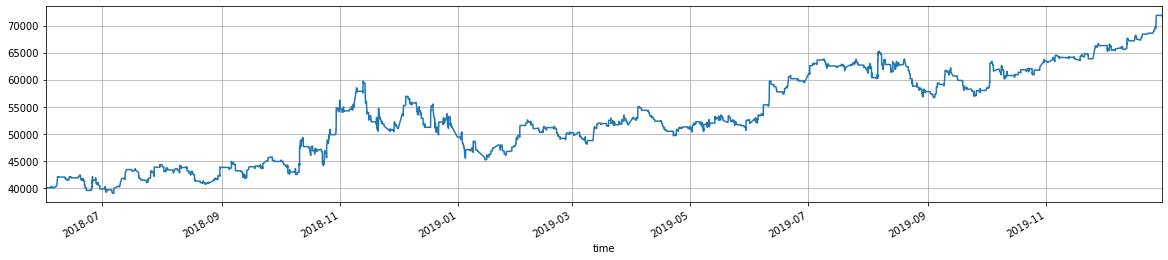

In [9]:
df.cash.plot(figsize=(20,4), grid=True);

In [10]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [11]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     386
 NQ    2452
 Name: action, dtype: int64, 2838)

In [12]:
# trades per day
days = len(by_contract.resample('D').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.667820
 NQ    4.242215
 Name: action, dtype: float64, 4.9100346020761245)

In [13]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     810.6
NQ    5149.2
Name: commission, dtype: float64

In [14]:
df.commission.sum()

5959.800000000001

In [15]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.39,15.43,384.54,-225.33,1.71,12.52,1226.0
ES,0.44,66.65,928.15,-611.38,1.52,66.01,193.0
total,0.40,22.40,465.75,-274.38,1.70,21.67,1419.0


In [16]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [17]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,NQ,total
contract,,,
ES,1.000000,0.133305,0.750487
NQ,0.133305,1.000000,0.754810
total,0.750487,0.754810,1.000000


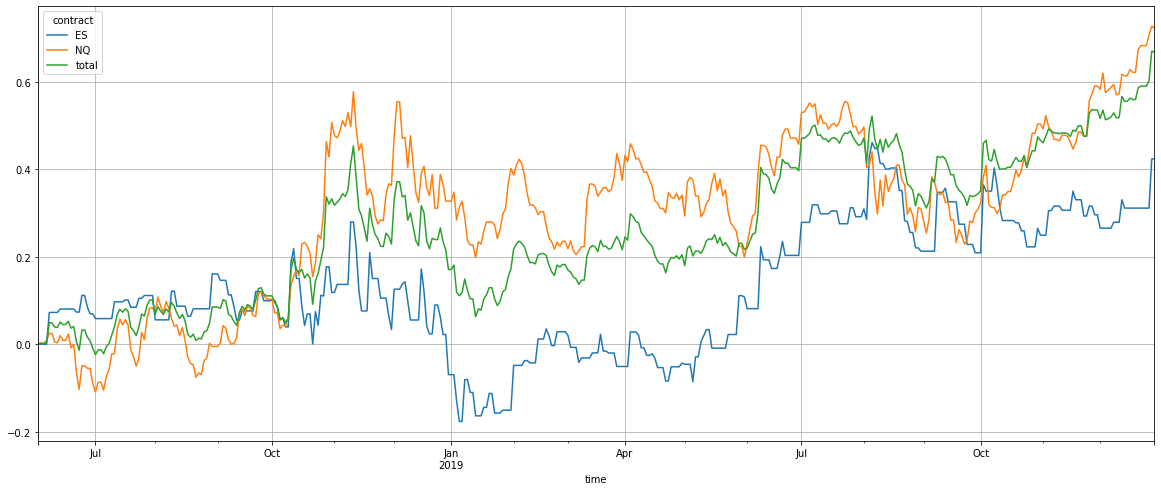

In [18]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

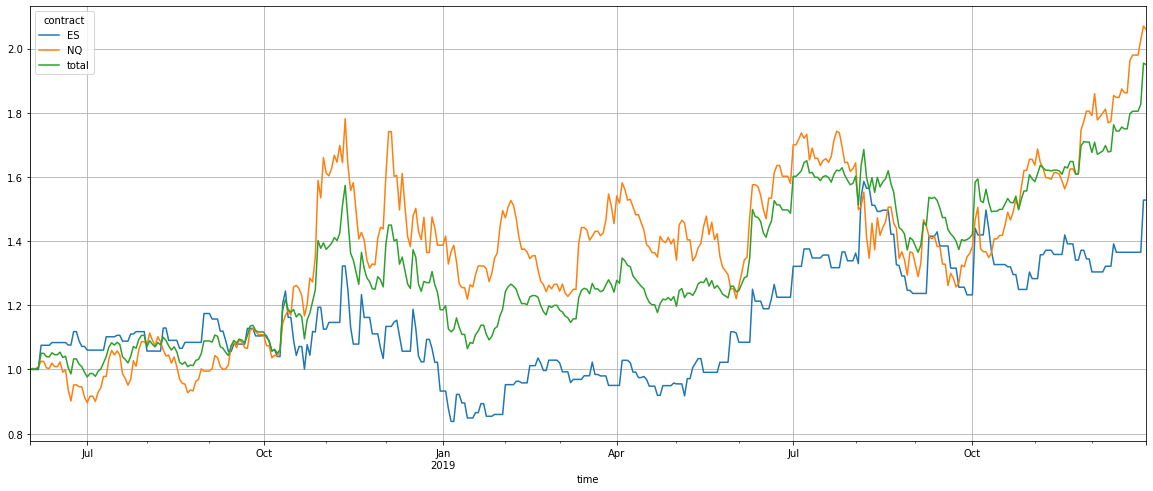

In [19]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [20]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,NQ,total
Annual return,0.296008,0.555616,0.504343
Cumulative returns,0.527934,1.059421,0.949612
Annual volatility,0.529125,0.526905,0.398192
Sharpe ratio,0.743540,1.098197,1.220607
Calmar ratio,0.808111,1.760827,1.558865
Stability,0.345520,0.609007,0.782450
Max drawdown,-0.366296,-0.315542,-0.323533
Omega ratio,1.214230,1.217571,1.263889
Sortino ratio,1.410986,1.799267,2.183269
Skew,1.987025,0.699499,1.339289


In [21]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,NQ,total
time,,,
2018-06-30,7.20,-8.57,-0.85
2018-07-31,4.28,18.85,11.58
2018-08-31,5.05,-8.44,-1.59
2018-09-30,-5.95,11.45,2.57
2018-10-31,1.91,49.69,24.86
2018-11-30,-8.13,-13.35,-9.83
2018-12-31,-9.80,-3.54,-5.66
2019-01-31,-7.81,7.77,0.16
2019-02-28,19.66,-15.36,0.99


In [22]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        53.0
NQ       106.0
total     95.0
dtype: float64

In [23]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:48:30,ES,BUY,2893.25,3370.8
2018-10-10 21:49:30,ES,BUY,2814.25,3183.3
2019-08-05 21:20:00,ES,BUY,2842.50,3120.8
2018-11-09 09:25:00,ES,SELL,2794.00,3070.8
2019-06-10 20:13:30,ES,SELL,2887.75,3045.8
...,...,...,...,...
2018-10-16 14:56:00,ES,BUY,2770.75,-1229.2
2018-10-12 21:09:00,ES,BUY,2759.00,-1316.7
2018-12-19 11:06:00,ES,BUY,2559.00,-1404.2


In [24]:
daily.sort_values('total', ascending=False)

contract,ES,NQ,total
time,,,
2018-10-29,0.069165,0.17670,0.122933
2018-10-10,0.159165,0.07740,0.118282
2019-10-02,0.168540,0.06045,0.114495
2019-06-10,0.152290,0.06662,0.109455
2018-12-03,0.096665,0.11712,0.106893
...,...,...,...
2018-10-22,-0.066045,-0.05201,-0.059027
2019-01-03,-0.058335,-0.06176,-0.060048
2018-12-19,-0.076670,-0.04797,-0.062320
